In [2]:
import pandas as pd
from pathlib import Path
import numpy as np

data_path = Path("cisa_kev_clean.csv")
df = pd.read_csv("../data/cisa_kev_clean.csv")


df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   cveID                       1442 non-null   object
 1   cveYear                     1442 non-null   int64 
 2   vendorProject               1442 non-null   object
 3   product                     1442 non-null   object
 4   vulnerabilityName           1442 non-null   object
 5   dateAdded                   1442 non-null   object
 6   dueDate                     1442 non-null   object
 7   shortDescription            1442 non-null   object
 8   requiredAction              1442 non-null   object
 9   knownRansomwareCampaignUse  1442 non-null   bool  
 10  notes                       1442 non-null   object
 11  cwes                        1281 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 125.5+ KB


In [3]:
# Convert date columns to proper datetime format
date_cols = ["dateAdded", "dueDate"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Extract year and month from the 'dateAdded' column
df["year_added"] = df["dateAdded"].dt.year
df["month_added"] = df["dateAdded"].dt.month

# Extract year and month from the 'dueDate' column
df["year_due"] = df["dueDate"].dt.year
df["month_due"] = df["dueDate"].dt.month

# Calculate lead time (number of days between added date and due date)
df["lead_time_days"] = (df["dueDate"] - df["dateAdded"]).dt.days

# Display the main transformed columns for verification
df[["dateAdded", "dueDate", "year_added", "month_added", "lead_time_days"]].head()


,dateAdded,dueDate,year_added,month_added,lead_time_days
0,2025-10-15,2025-11-05,2025,10,21
1,2025-10-14,2025-11-04,2025,10,21
2,2025-10-14,2025-11-04,2025,10,21
3,2025-10-14,2025-11-04,2025,10,21
4,2025-10-14,2025-11-04,2025,10,21


In [6]:
import ast
import re

def clean_cwe(value):
    # If value is missing → return empty list
    if pd.isna(value):
        return []
    
    # Case 1: value looks like a Python list string → use ast.literal_eval
    if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
        try:
            parsed = ast.literal_eval(value)   # Convert string list → actual list
            # Clean each element
            return [item.strip() for item in parsed if "CWE-" in item]
        except:
            pass  # If parsing fails, fallback to regex
    
    # Case 2: normal text, separated by commas/semicolons
    parts = re.split(r"[;,/]", str(value))
    parts = [p.strip() for p in parts if p.strip().startswith("CWE-")]
    
    return parts

# Apply the function
df["cwe_list"] = df["cwes"].apply(clean_cwe)

# Count number of CWE classifications
df["cwe_count"] = df["cwe_list"].apply(len)

df[["cwes", "cwe_list", "cwe_count"]].head(10)


,cwes,cwe_list,cwe_count
0,NaN,[],0
1,['CWE-324'],[CWE-324],1
2,['CWE-822'],[CWE-822],1
3,['CWE-284'],[CWE-284],1
4,['CWE-276'],[CWE-276],1
5,['CWE-287'],[CWE-287],1
6,['CWE-22'],[CWE-22],1
7,['CWE-79'],[CWE-79],1
8,['CWE-787'],[CWE-787],1
9,NaN,[],0


In [7]:
# Categorize response speed based on lead time
def categorize_speed(days):
    # Handle missing or invalid values
    if pd.isna(days):
        return "Unknown"
    
    # Negative lead times (dueDate < dateAdded) → treat as urgent fast fixes
    if days < 0:
        return "Fast"
    
    # Classification based on response ranges
    if days <= 30:
        return "Fast"
    elif days <= 90:
        return "Medium"
    else:
        return "Slow"

# Apply classifier to the dataset
df["response_speed"] = df["lead_time_days"].apply(categorize_speed)

# Display a sample
df[["lead_time_days", "response_speed"]].head(20)


,lead_time_days,response_speed
0,21,Fast
1,21,Fast
2,21,Fast
3,21,Fast
4,21,Fast
5,21,Fast
6,21,Fast
7,21,Fast
8,21,Fast
9,21,Fast


In [8]:
# Assign severity weights based on CWE category
def cwe_severity_score(cwe_list):
    if not cwe_list:
        return 0
    
    score = 0
    # Weight rules
    for cwe in cwe_list:
        if "79" in cwe:        # XSS
            score += 2
        elif "787" in cwe or "125" in cwe:   # Memory bounds / buffer overflow
            score += 4
        elif "22" in cwe:      # Path Traversal
            score += 4
        elif "284" in cwe:     # Access Control
            score += 3
        elif "287" in cwe:     # Authentication Bypass
            score += 4
        else:
            score += 1   # default minor weight
    
    return score


# Ransomware weight
def ransomware_weight(flag):
    return 5 if flag else 0


# Response speed penalty
def response_speed_penalty(speed):
    if speed == "Fast":
        return 0
    elif speed == "Medium":
        return 2
    else:
        return 5


# Vendor risk baseline
high_risk_vendors = ["Microsoft", "Cisco", "Adobe", "Google", "Fortinet"]
def vendor_risk(vendor):
    return 3 if vendor in high_risk_vendors else 1


# Final severity score
def compute_severity(row):
    return (
        cwe_severity_score(row["cwe_list"]) +
        ransomware_weight(row["knownRansomwareCampaignUse"]) +
        response_speed_penalty(row["response_speed"]) +
        vendor_risk(row["vendorProject"])
    )

# Apply to dataset
df["severity_score"] = df.apply(compute_severity, axis=1)

df[["cveID", "cwe_list", "response_speed", "knownRansomwareCampaignUse", "severity_score"]].head(15)


,cveID,cwe_list,response_speed,knownRansomwareCampaignUse,severity_score
0,CVE-2025-54253,[],Fast,False,3
1,CVE-2025-47827,[CWE-324],Fast,False,2
2,CVE-2025-24990,[CWE-822],Fast,False,7
3,CVE-2025-59230,[CWE-284],Fast,False,6
4,CVE-2025-6264,[CWE-276],Fast,True,7
5,CVE-2016-7836,[CWE-287],Fast,False,5
6,CVE-2021-43798,[CWE-22],Fast,False,5
7,CVE-2025-27915,[CWE-79],Fast,False,3
8,CVE-2021-22555,[CWE-787],Fast,False,5
9,CVE-2010-3962,[],Fast,False,3


In [13]:
def classify_severity(score):
    if score <= 3:
        return "Low Risk"
    elif score <= 6:
        return "Moderate Risk"
    elif score <= 10:
        return "High Risk"
    elif score <= 14:
        return "Severe Risk"
    else:
        return "Critical Risk"

df["severity_label"] = df["severity_score"].apply(classify_severity)

df[["cveID", "severity_score", "severity_label"]].head(20)


def highlight_row(row):
    color = row["severity_color"]
    return [f"background-color: {color}; color: white;" for _ in row]

styled_df = df[["cveID", "severity_score", "severity_label", "severity_color"]].style.apply(
    highlight_row, axis=1
)

styled_df



,cveID,severity_score,severity_label,severity_color
0,CVE-2025-54253,3,Low Risk,#4CAF50
1,CVE-2025-47827,2,Low Risk,#4CAF50
2,CVE-2025-24990,7,High Risk,#FF9800
3,CVE-2025-59230,6,Moderate Risk,#FFC107
4,CVE-2025-6264,7,High Risk,#FF9800
5,CVE-2016-7836,5,Moderate Risk,#FFC107
6,CVE-2021-43798,5,Moderate Risk,#FFC107
7,CVE-2025-27915,3,Low Risk,#4CAF50
8,CVE-2021-22555,5,Moderate Risk,#FFC107
9,CVE-2010-3962,3,Low Risk,#4CAF50


In [14]:
# Filter High, Severe, and Critical risks
high_critical = df[df["severity_label"].isin(["High Risk", "Severe Risk", "Critical Risk"])]

# Prepare a professional table
top_risks = high_critical[[
    "cveID",
    "vendorProject",
    "product",
    "cwe_list",
    "severity_label",
    "severity_score",
    "lead_time_days",
    "knownRansomwareCampaignUse",
    "dateAdded",
    "dueDate"
]].sort_values(by="severity_score", ascending=False)

top_risks.head(20)


,cveID,vendorProject,product,cwe_list,severity_label,severity_score,lead_time_days,knownRansomwareCampaignUse,dateAdded,dueDate
1242,CVE-2020-12812,Fortinet,FortiOS,"[CWE-178, CWE-287]",Critical Risk,18,181,True,2021-11-03,2022-05-03
1333,CVE-2019-1367,Microsoft,Internet Explorer,[CWE-787],Critical Risk,17,181,True,2021-11-03,2022-05-03
1124,CVE-2018-13383,Fortinet,FortiOS and FortiProxy,[CWE-787],Critical Risk,17,181,True,2022-01-10,2022-07-10
1281,CVE-2020-0878,Microsoft,Edge and Internet Explorer,[CWE-787],Critical Risk,17,181,True,2021-11-03,2022-05-03
1068,CVE-2018-8174,Microsoft,Windows,[CWE-787],Critical Risk,17,181,True,2022-02-15,2022-08-15
1243,CVE-2018-13379,Fortinet,FortiOS,[CWE-22],Critical Risk,17,181,True,2021-11-03,2022-05-03
1303,CVE-2020-0688,Microsoft,Exchange Server,[CWE-287],Critical Risk,17,181,True,2021-11-03,2022-05-03
1224,CVE-2019-19781,Citrix,"Application Delivery Controller (ADC), Gateway...",[CWE-22],Critical Risk,15,181,True,2021-11-03,2022-05-03
1238,CVE-2020-5902,F5,BIG-IP,[CWE-22],Critical Risk,15,181,True,2021-11-03,2022-05-03
1094,CVE-2020-0787,Microsoft,Windows,"[CWE-269, CWE-59]",Critical Risk,15,181,True,2022-01-28,2022-07-28


C:\Users\asus\AppData\Local\Temp\ipykernel_25680\3866425495.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors.values, y=top_vendors.index, palette="rocket")


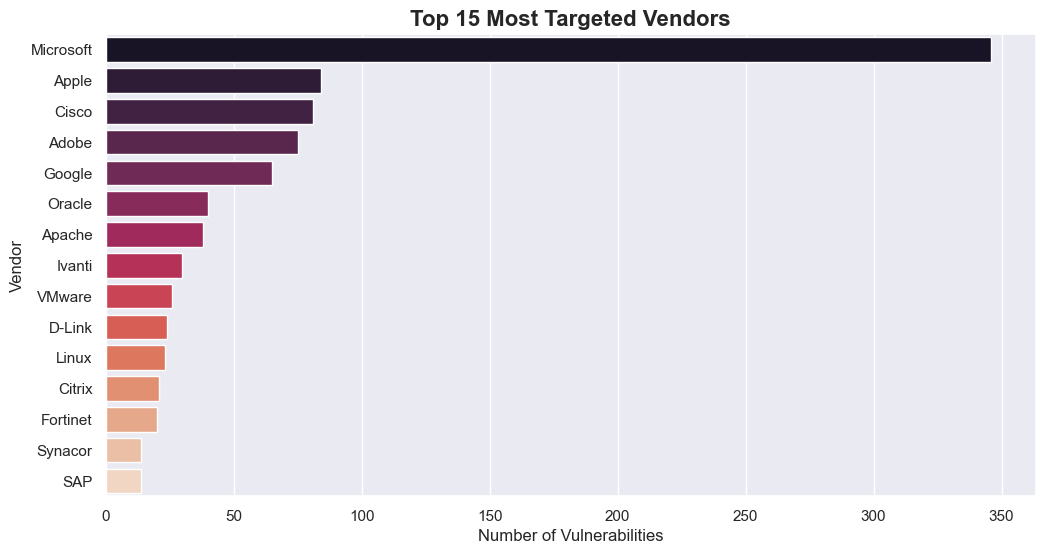

vendorProject
Microsoft    346
Apple         84
Cisco         81
Adobe         75
Google        65
Oracle        40
Apache        38
Ivanti        30
VMware        26
D-Link        24
Linux         23
Citrix        21
Fortinet      20
Synacor       14
SAP           14
Name: count, dtype: int64

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 most affected vendors
top_vendors = (
    df["vendorProject"]
    .value_counts()
    .head(15)
)

plt.figure(figsize=(12,6))

sns.set_theme(style="darkgrid")
sns.barplot(x=top_vendors.values, y=top_vendors.index, palette="rocket")

plt.title("Top 15 Most Targeted Vendors", fontsize=16, fontweight="bold")
plt.xlabel("Number of Vulnerabilities")
plt.ylabel("Vendor")
plt.show()


top_vendors



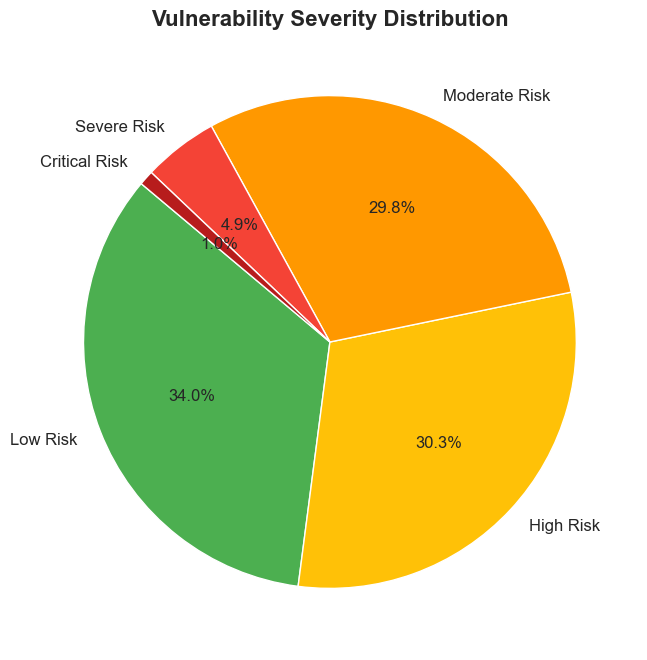

severity_label
Low Risk         491
High Risk        437
Moderate Risk    429
Severe Risk       71
Critical Risk     14
Name: count, dtype: int64

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

severity_counts = df["severity_label"].value_counts()

plt.figure(figsize=(8, 8))
colors = ["#4CAF50", "#FFC107", "#FF9800", "#F44336", "#B71C1C"]

plt.pie(
    severity_counts.values,
    labels=severity_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)

plt.title("Vulnerability Severity Distribution", fontsize=16, fontweight="bold")
plt.show()

severity_counts


C:\Users\asus\AppData\Local\Temp\ipykernel_25680\289365654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


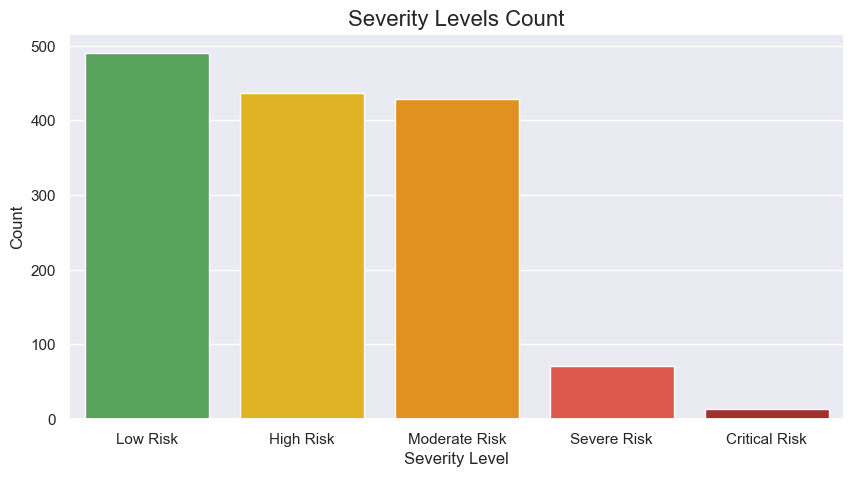

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(
    x=severity_counts.index,
    y=severity_counts.values,
    palette=colors
)

plt.title("Severity Levels Count", fontsize=16)
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()


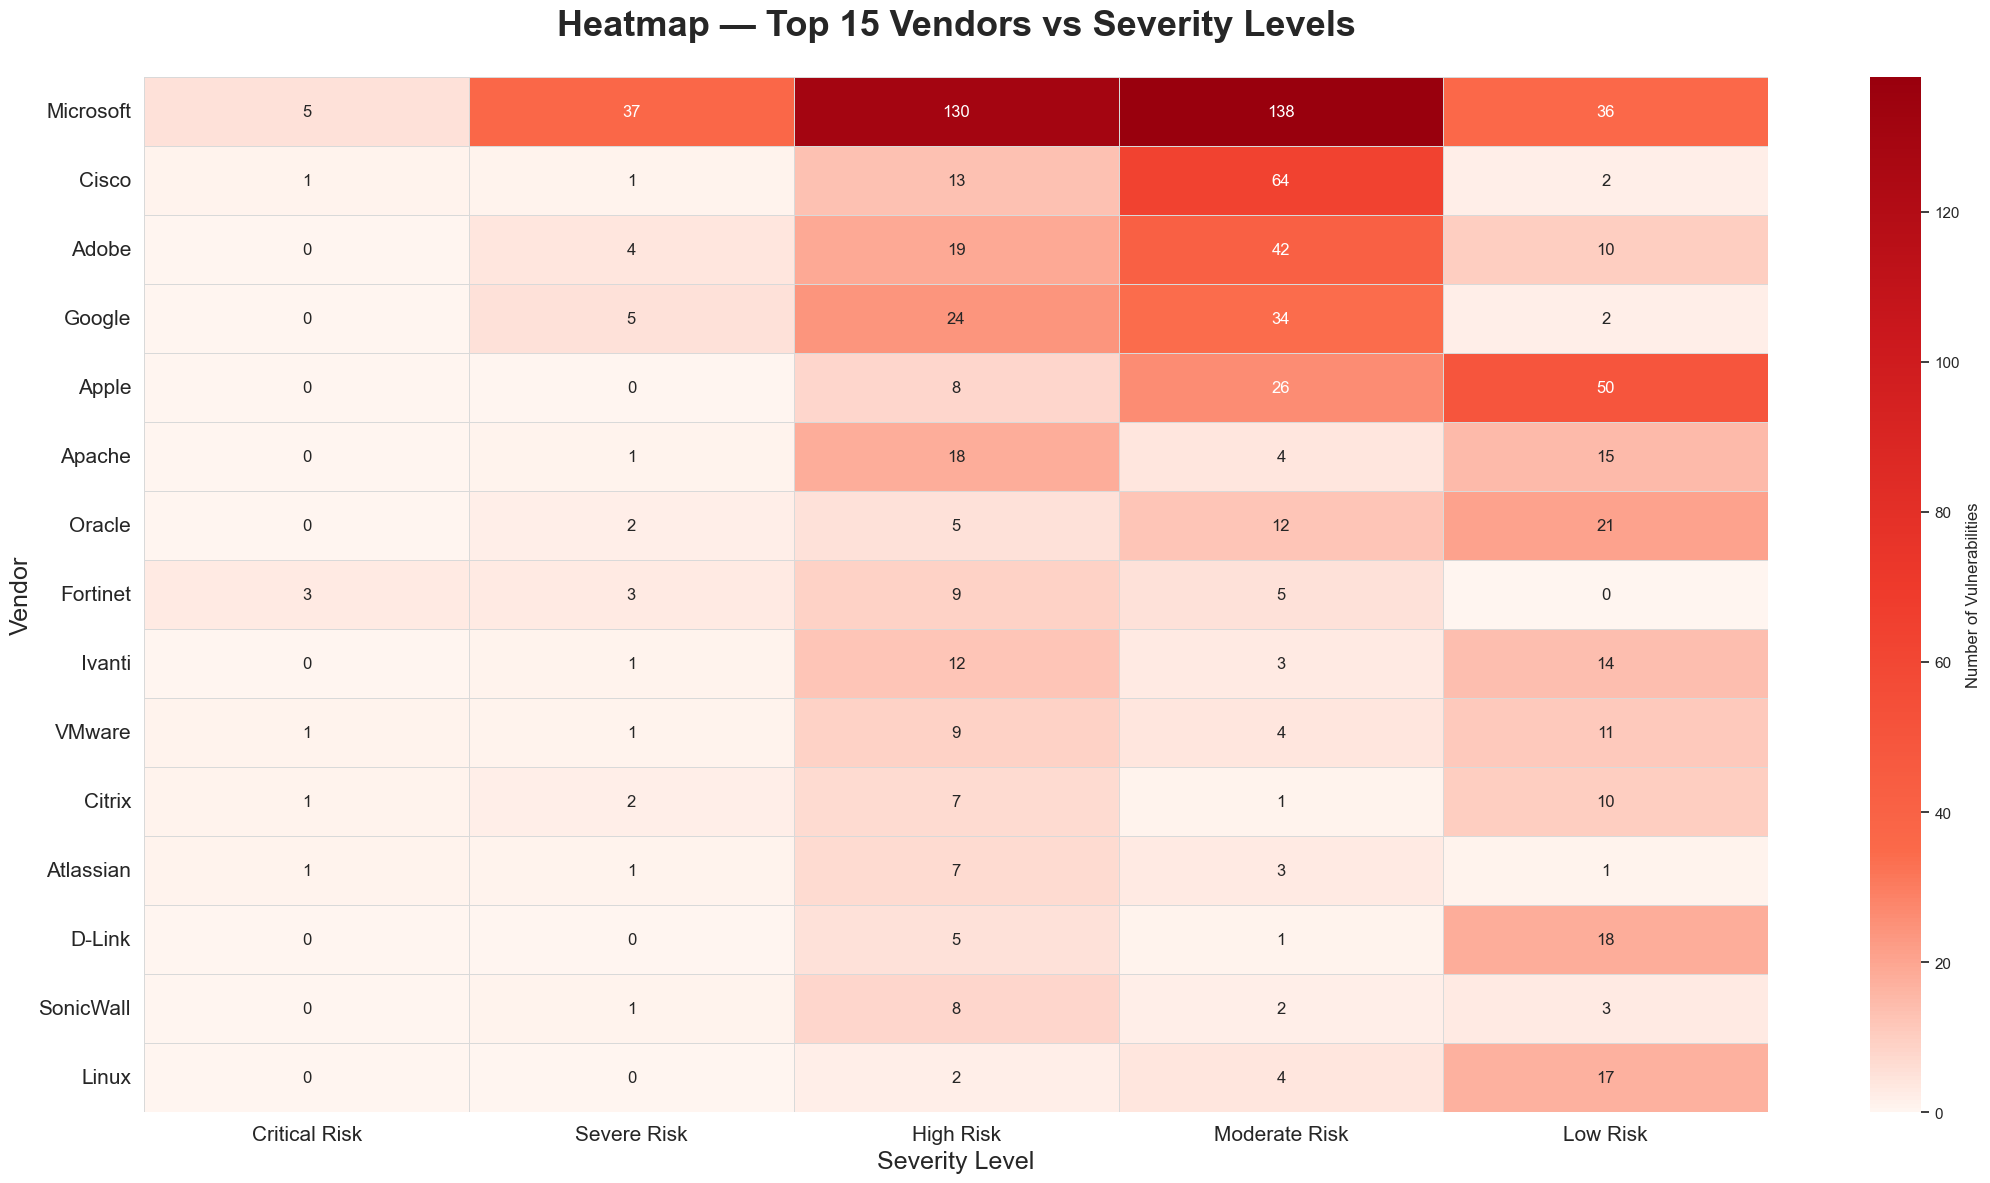

In [31]:
# -------------------------------------------------------
# FINAL ULTRA-PROFESSIONAL HEATMAP (Perfect Version)
# -------------------------------------------------------

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1) Pivot Table
pivot = df.pivot_table(
    values="cveID",
    index="vendorProject",
    columns="severity_label",
    aggfunc="count",
    fill_value=0
)

# 2) Correct order
severity_order = ["Critical Risk", "Severe Risk", "High Risk", "Moderate Risk", "Low Risk"]
pivot = pivot.reindex(columns=severity_order)

# 3) Weighted sorting
pivot["severity_rank"] = (
    pivot["Critical Risk"]*5 +
    pivot["Severe Risk"]*4 +
    pivot["High Risk"]*3 +
    pivot["Moderate Risk"]*2 +
    pivot["Low Risk"]*1
)
pivot = pivot.sort_values("severity_rank", ascending=False)
pivot = pivot.drop(columns=["severity_rank"])

# 4) Top 15 vendors
top15 = pivot.head(15)

# 5) Custom colormap with very light color for empty cells
colors = [
    "#fff5f0",  # Very light for zero/near zero
    "#fb6a4a",  # Light red
    "#ef3b2c",  # Red
    "#cb181d",  # Dark red
    "#99000d"   # Very dark for extremely high
]
cmap = LinearSegmentedColormap.from_list("ultra_heatmap", colors)

plt.figure(figsize=(22, 12))

# 6) Heatmap (WITHOUT replacing zeros)
sns.heatmap(
    top15,
    annot=True,
    fmt="g",
    cmap=cmap,
    linewidths=0.7,
    linecolor="#d9d9d9",
    cbar_kws={"label": "Number of Vulnerabilities"},
    square=False
)

plt.title(
    "Heatmap — Top 15 Vendors vs Severity Levels",
    fontsize=26,
    fontweight="bold",
    pad=30
)

plt.xlabel("Severity Level", fontsize=18)
plt.ylabel("Vendor", fontsize=18)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.tight_layout()
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_25680\384294490.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


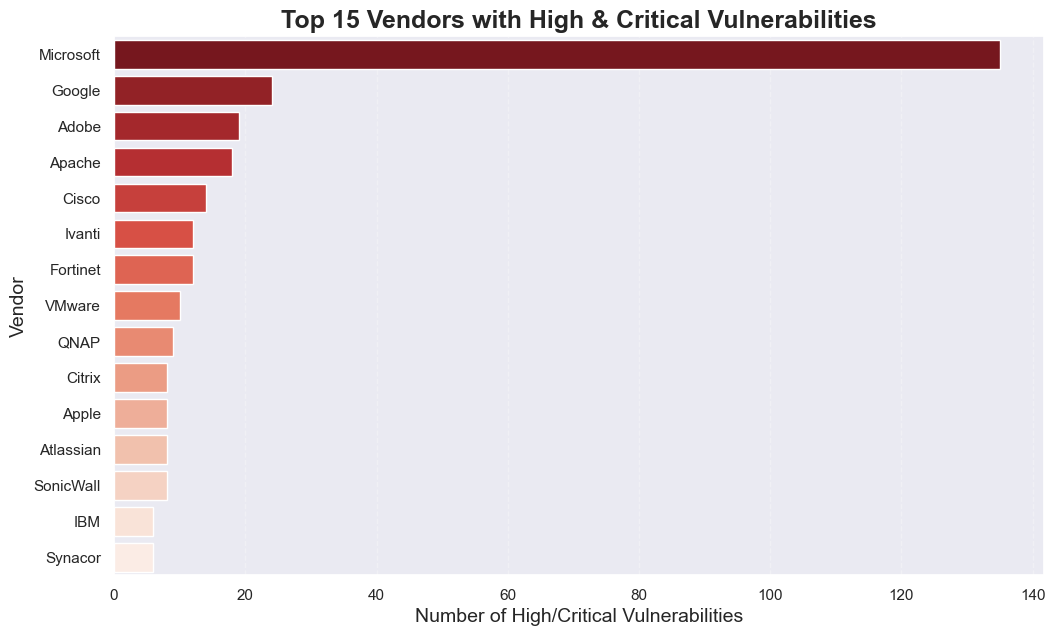

In [32]:
# Next Cell: Top Vendors with High + Critical Vulnerabilities

# Combine High + Critical into one metric
df['high_critical'] = df.apply(
    lambda x: x['severity_label'] in ['High Risk', 'Critical Risk'], axis=1
)

# Count occurrences
top_dangerous = (
    df[df['severity_label'].isin(['High Risk', 'Critical Risk'])]
    .groupby('vendorProject')
    .size()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(12, 7))
sns.barplot(
    x=top_dangerous.values,
    y=top_dangerous.index,
    palette="Reds_r"
)

plt.title("Top 15 Vendors with High & Critical Vulnerabilities", fontsize=18, fontweight="bold")
plt.xlabel("Number of High/Critical Vulnerabilities", fontsize=14)
plt.ylabel("Vendor", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()


In [34]:
df.columns


Index(['cveID', 'cveYear', 'vendorProject', 'product', 'vulnerabilityName',
       'dateAdded', 'dueDate', 'shortDescription', 'requiredAction',
       'knownRansomwareCampaignUse', 'notes', 'cwes', 'year_added',
       'month_added', 'year_due', 'month_due', 'lead_time_days', 'cwe_list',
       'cwe_count', 'response_speed', 'severity_score', 'severity_label',
       'severity_color', 'severity_weight', 'high_critical'],
      dtype='object')

In [36]:
df.columns.tolist()


['cveID',
 'cveYear',
 'vendorProject',
 'product',
 'vulnerabilityName',
 'dateAdded',
 'dueDate',
 'shortDescription',
 'requiredAction',
 'knownRansomwareCampaignUse',
 'notes',
 'cwes',
 'year_added',
 'month_added',
 'year_due',
 'month_due',
 'lead_time_days',
 'cwe_list',
 'cwe_count',
 'response_speed',
 'severity_score',
 'severity_label',
 'severity_color',
 'severity_weight',
 'high_critical']

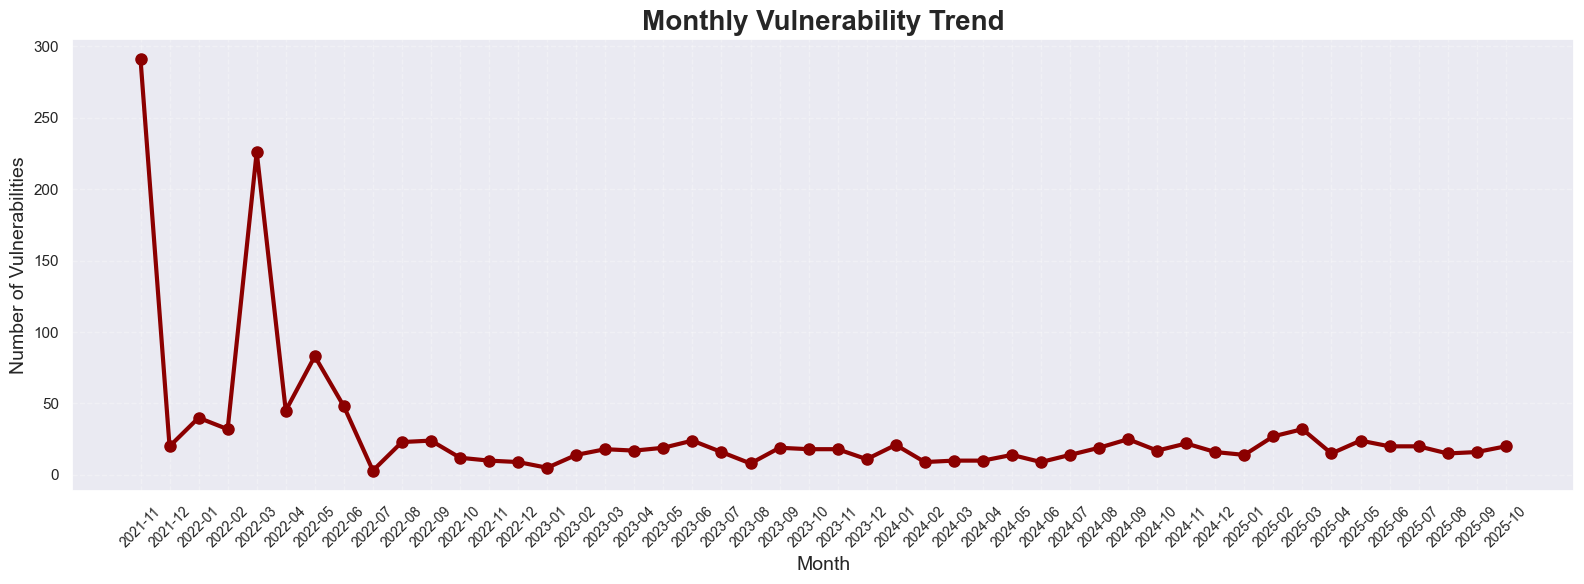

In [42]:

# Convert the 'dateAdded' column into proper datetime format

df["dateAdded"] = pd.to_datetime(df["dateAdded"], errors='coerce')

# Extract Year-Month for time-series grouping (YYYY-MM)

df["year_month"] = df["dateAdded"].dt.strftime("%Y-%m")


# Count vulnerabilities per month

monthly_trend = df["year_month"].value_counts().sort_index()

# Plot a professional time-series line chart
plt.figure(figsize=(16, 6))

plt.plot(
    monthly_trend.index,
    monthly_trend.values,
    marker="o",
    linewidth=3,
    markersize=8,
    color="#8B0000"  # Dark Crimson
)

# Chart Styling for Ultra Professional Look
plt.title("Monthly Vulnerability Trend", fontsize=20, weight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Vulnerabilities", fontsize=14)
plt.grid(alpha=0.3, linestyle="--")

# Rotate x-labels for readability
plt.xticks(rotation=45, fontsize=10)

plt.tight_layout()
plt.show()


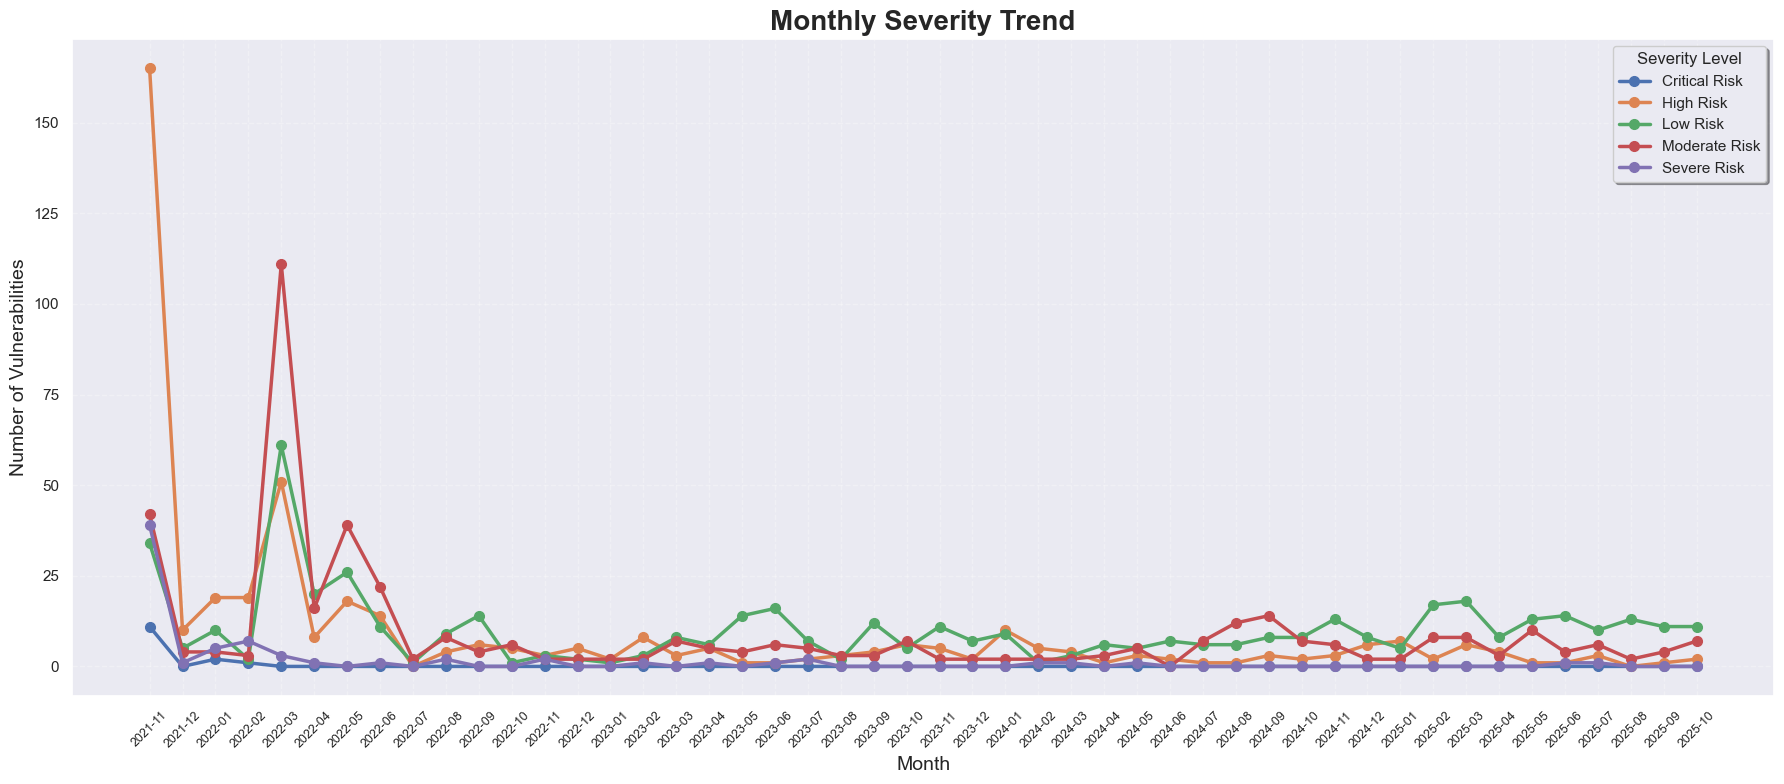

In [41]:
# Prepare monthly severity trend data

# Ensure dateAdded is datetime
df["dateAdded"] = pd.to_datetime(df["dateAdded"], errors="coerce")

# Extract year-month
df["year_month"] = df["dateAdded"].dt.to_period("M").astype(str)

# Group by severity label + month
severity_monthly = (
    df.groupby(["year_month", "severity_label"])
      .size()
      .unstack(fill_value=0)
)

# Plot a multi-line trend chart
plt.figure(figsize=(18, 8))

for severity in severity_monthly.columns:
    plt.plot(
        severity_monthly.index,
        severity_monthly[severity],
        marker="o",
        linewidth=2.5,
        markersize=7,
        label=severity
    )

# Professional Styling
plt.title("Monthly Severity Trend", fontsize=20, weight="bold")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Vulnerabilities", fontsize=14)
plt.xticks(rotation=45, fontsize=9)
plt.grid(alpha=0.3, linestyle="--")

plt.legend(
    title="Severity Level",
    title_fontsize=12,
    fontsize=11,
    loc="upper right",
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.tight_layout()
plt.show()


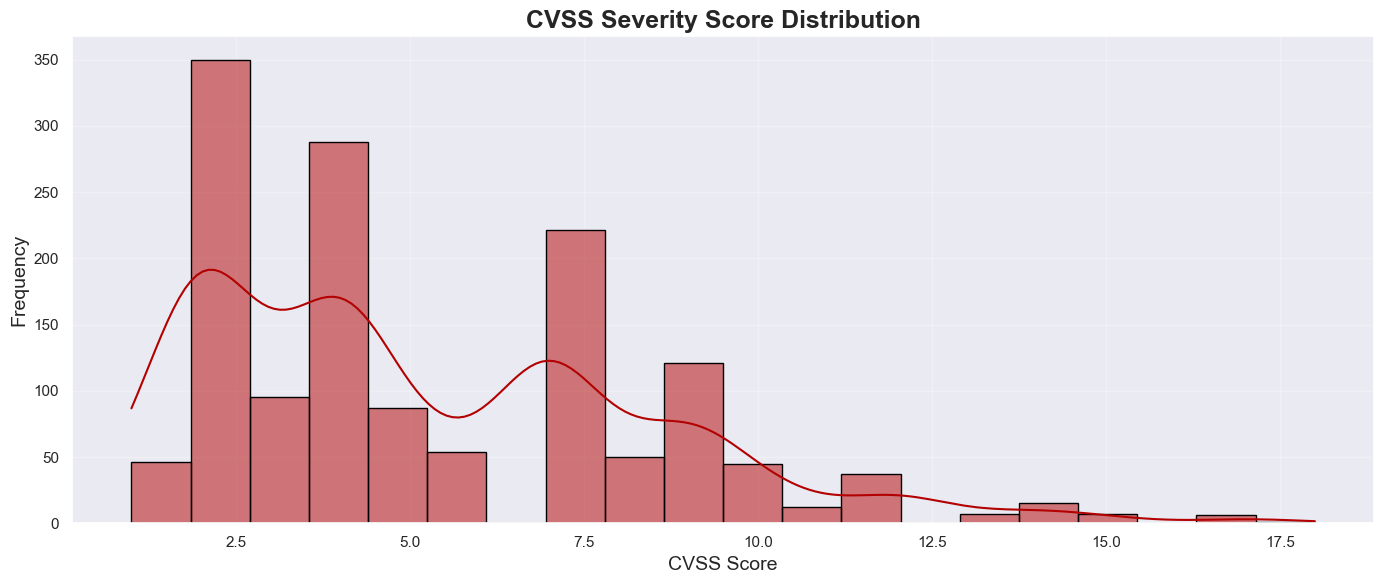

In [40]:
# CVSS Score Distribution (Histogram + KDE)

plt.figure(figsize=(14, 6))
sns.histplot(
    df["severity_score"],
    bins=20,
    kde=True,
    color="#b30000",
    edgecolor="black"
)

# Styling
plt.title("CVSS Severity Score Distribution", fontsize=18, weight="bold")
plt.xlabel("CVSS Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.25)

plt.tight_layout()
plt.show()


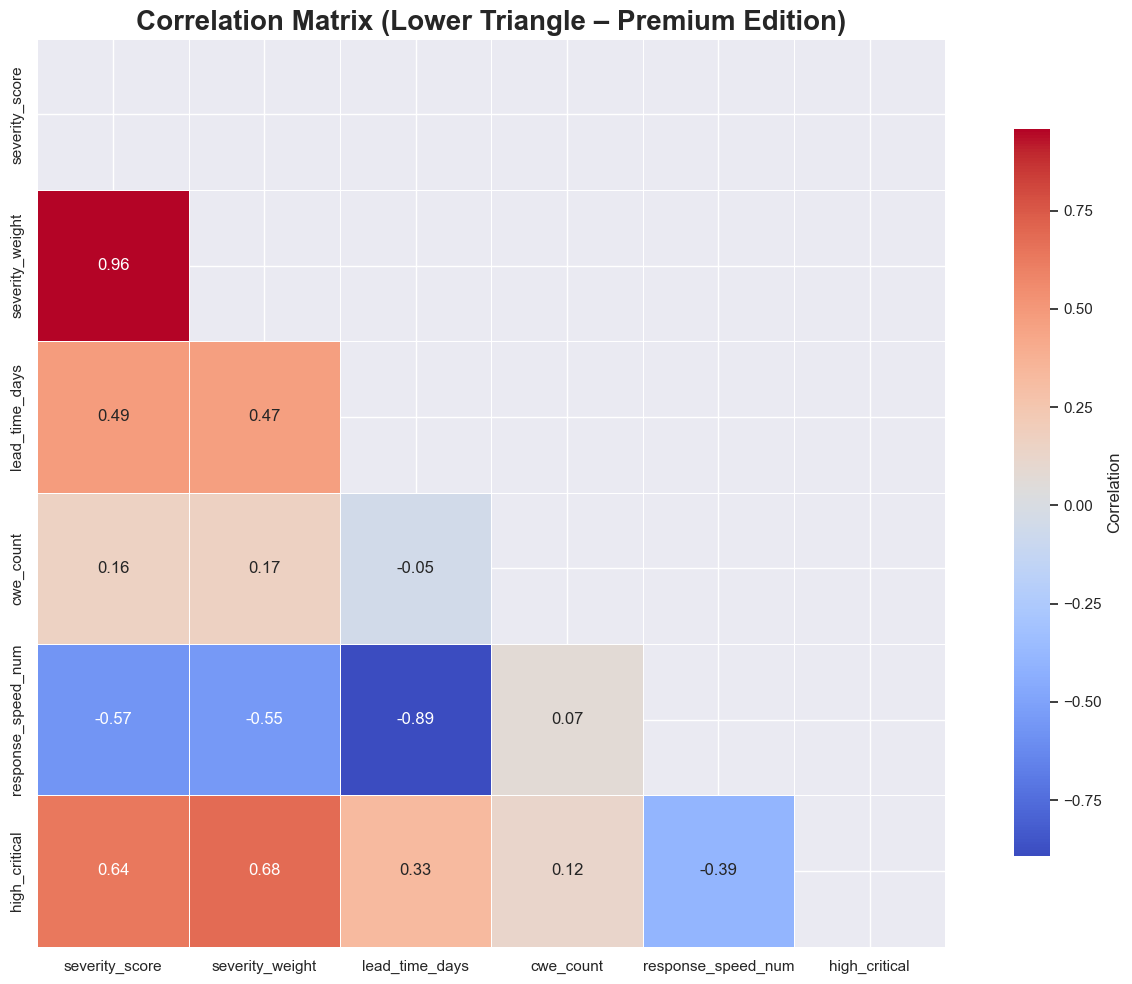

In [49]:
# ---------------------------------------------------------
# Ultra-Premium Correlation Heatmap (Masked + Clean Design)
# ---------------------------------------------------------

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_matrix,
    mask=mask,         # hide upper triangle
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    annot_kws={"size": 12}
)

plt.title("Correlation Matrix (Lower Triangle – Premium Edition)", fontsize=20, weight="bold")
plt.tight_layout()
plt.show()


In [53]:
# ==========================================
# FINAL CLEAN & ACCURATE CORRELATION EXTRACTION
# ==========================================

# Compute correlation matrix
corr = df[corr_features].corr()

# Drop diagonal (self-correlation)
corr_no_diag = corr.where(~np.eye(corr.shape[0], dtype=bool))

# Convert to series
corr_series = corr_no_diag.stack()

# Keep each pair only once (A < B)
clean_corr = corr_series[corr_series.index.get_level_values(0) < corr_series.index.get_level_values(1)]

# Split into positive and negative
pos_corr = clean_corr[clean_corr > 0].sort_values(ascending=False)
neg_corr = clean_corr[clean_corr < 0].sort_values()

# Select top 10 each
top10_pos = pos_corr.head(10)
top10_neg = neg_corr.head(10)

# Print in clean display
print("\n🔵 TOP 10 STRONGEST POSITIVE CORRELATIONS:\n")
print(top10_pos)

print("\n🔴 TOP 10 STRONGEST NEGATIVE CORRELATIONS:\n")
print(top10_neg)



🔵 TOP 10 STRONGEST POSITIVE CORRELATIONS:

severity_score  severity_weight       0.956510
high_critical   severity_weight       0.683679
                severity_score        0.637994
lead_time_days  severity_score        0.485159
                severity_weight       0.471159
high_critical   lead_time_days        0.327302
cwe_count       severity_weight       0.166114
                severity_score        0.155275
                high_critical         0.119366
                response_speed_num    0.069698
dtype: float64

🔴 TOP 10 STRONGEST NEGATIVE CORRELATIONS:

lead_time_days      response_speed_num   -0.891619
response_speed_num  severity_score       -0.572784
                    severity_weight      -0.548886
high_critical       response_speed_num   -0.393979
cwe_count           lead_time_days       -0.052771
dtype: float64


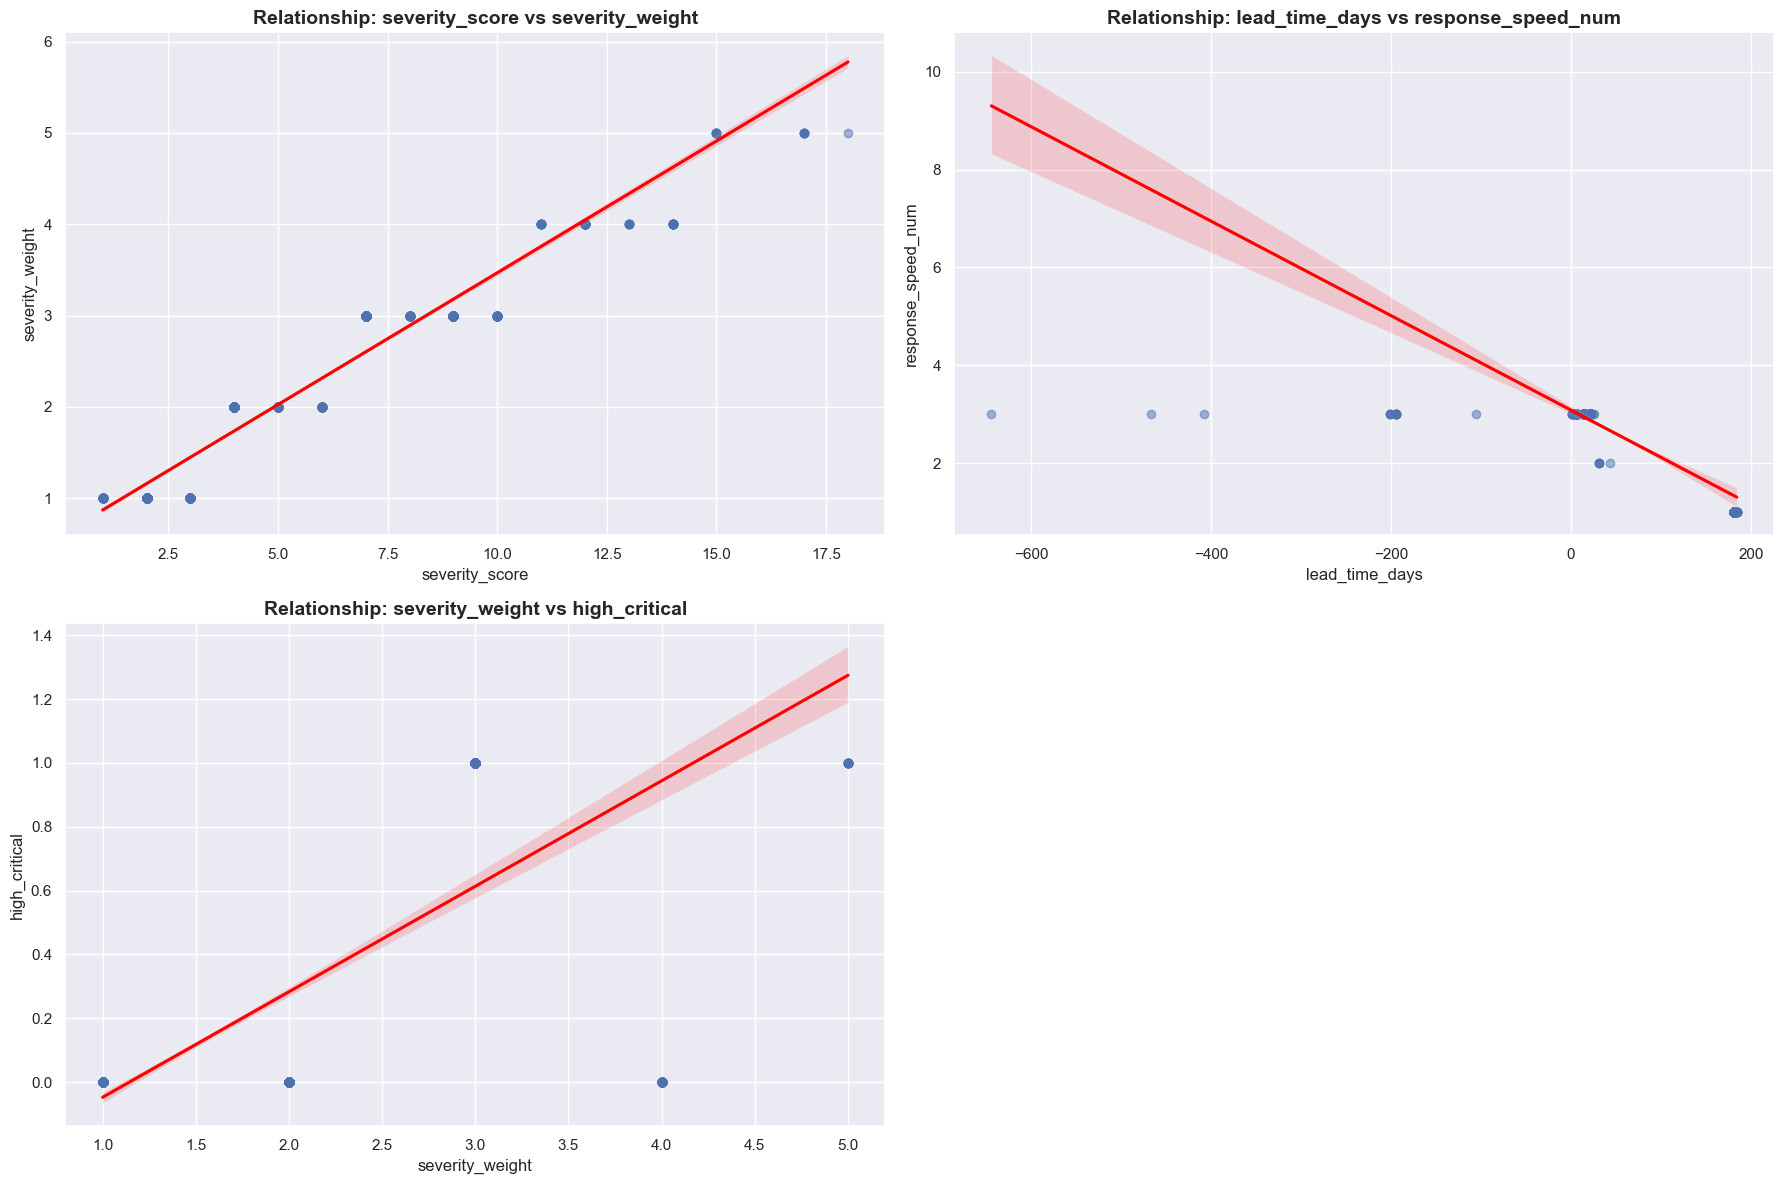

In [48]:
# ---------------------------------------------------------
# Scatter Plots for Strongest Relationships
# ---------------------------------------------------------
strong_pairs = [
    ("severity_score", "severity_weight"),
    ("lead_time_days", "response_speed_num"),
    ("severity_weight", "high_critical"),
]

plt.figure(figsize=(18, 12))

for i, (x, y) in enumerate(strong_pairs, 1):
    plt.subplot(2, 2, i)
    sns.regplot(data=df, x=x, y=y, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
    plt.title(f"Relationship: {x} vs {y}", fontsize=14, weight="bold")
    plt.xlabel(x)
    plt.ylabel(y)

plt.tight_layout()
plt.show()


In [47]:
# ---------------------------------------------------------
# TOP POSITIVE & NEGATIVE CORRELATIONS (ULTRA PROFESSIONAL)
# ---------------------------------------------------------

# Take the correlation matrix
corr = corr_matrix.copy()

# Remove self-correlations on the diagonal
np.fill_diagonal(corr.values, np.nan)

# Unstack matrix → turn into list of pairs
corr_pairs = corr.unstack().dropna()

# Sort by absolute value (strongest first)
sorted_corr = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)

# Display Top 10 Positive
print("🔹 TOP 10 STRONGEST POSITIVE CORRELATIONS:\n")
display(sorted_corr[sorted_corr > 0].head(10))

# Display Top 10 Negative
print("\n🔹 TOP 10 STRONGEST NEGATIVE CORRELATIONS:\n")
display(sorted_corr[sorted_corr < 0].head(10))



🔹 TOP 10 STRONGEST POSITIVE CORRELATIONS:



severity_score   severity_weight    0.956510
severity_weight  severity_score     0.956510
high_critical    severity_weight    0.683679
severity_weight  high_critical      0.683679
severity_score   high_critical      0.637994
high_critical    severity_score     0.637994
lead_time_days   severity_score     0.485159
severity_score   lead_time_days     0.485159
lead_time_days   severity_weight    0.471159
severity_weight  lead_time_days     0.471159
dtype: float64


🔹 TOP 10 STRONGEST NEGATIVE CORRELATIONS:



lead_time_days      response_speed_num   -0.891619
response_speed_num  lead_time_days       -0.891619
                    severity_score       -0.572784
severity_score      response_speed_num   -0.572784
severity_weight     response_speed_num   -0.548886
response_speed_num  severity_weight      -0.548886
high_critical       response_speed_num   -0.393979
response_speed_num  high_critical        -0.393979
lead_time_days      cwe_count            -0.052771
cwe_count           lead_time_days       -0.052771
dtype: float64